### Building a text classifier using a supervised machine learning approach

##### Author: Lucy Dickinson

##### Task: Build a text classifier for online article submissions

The aim of this analysis is to build a text classifier to automatically categorise titles of academic articles into academic fields of research. In a real world scenario, depoloying such a classifier would allow near real time classification of any articles submitted into a database and reduce manual classification.

The data contain the titles of articles published in the Open Access journal Nature Communications between 2018 and 2019. I am not the owner of the dataset so I cannot provide access to this data, I am merely demonstrating my jupyter notebook and how I would go about training a supervised machine learning classifier.

First of all, I will cover the steps involved in building a text classifier. You can find a more in depth overview in my article <a href='https://medium.com/towards-data-science/step-by-step-basics-text-classifier-e666c6bac52b'>here</a>, which was published in Towards Data Science.

### Steps for building a text classifier

There are a number of required data processing steps that must be completed in a specific order to successfully build a text classifier. I will list these steps below, along with a short definition. Note I will go into more detail of each step as we work through the notebook.

1. <strong>Clarify task and required data to solve the task</strong>
2. <strong>Data quality checks</strong>
    - remove duplicates/null rows
3. <strong>Exploratory Data Analysis (EDA)</strong>
    - This step is very important (for any analytical task!). Get to know your data, especially the quirks. Understanding the patterns within the data will determine how you conduct the analysis.
    - Class distribution - the distribution of values for each class/category (the one you're trying to predict) in the dataset. If this is imbalanced (one class is very prevalent in the dataset whilst others are very underrepresented), extra pre-processing steps will be required to balance the class distribution. 
4. <strong>Text pre-processing</strong>
    - Removing unwanted characters that are not indicative of the class you are trying to predict, including:
        - <strong>Punctuation/special characters</strong>
        - <strong>Stop words</strong> (the, a, this, etc.)
        - <strong>Lemmatisation or stemming</strong> - reducing the word to its root form to reduce noise within the dataset (e.g. transforms 'sailing' and 'sailed' into 'sail'. 
        - <strong>Vectorisation</strong> - transforming the data into 'vectors', where each word becomes a feature (column) which can take a value of 0 or 1, depending on whether that word was present in that row of data or not.
            - Note. there are different forms of vectorisation which I will cover in this section of the notebook.
5. <strong>Model selection</strong>
    - Iteratively test a few different types of models to see which performs best on the data and the task
6. <strong>Baseline model performance</strong>
    - Once you have selected the model you want to use in the analysis, train and test the model to get the performance metrics of the model BEFORE you fine tune it/perform feature engineering. As such, you can compare the performance of any future iterations with the baseline performance to gain an understanding of whether the change you made improved or worsened the model.
7. <strong>Hyperparameter tuning & feature engineering</strong>
    - These are the tweaks you can make to the model to help improve model performance.
8. <strong>Save trained classifier for re-use</strong>

In [2]:
#  importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from tqdm.notebook import tqdm

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, StratifiedKFold
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from collections import Counter

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline, make_pipeline

import nlpaug.augmenter.word as naw

In [3]:
nltk.download('wordnet') 
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lucy_dickinson\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lucy_dickinson\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lucy_dickinson\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
pd.set_option('display.max_columns', 10)
# Stop string truncation
pd.set_option('display.max_colwidth', None)
np.set_printoptions(linewidth=np.inf)

### 1. Data input

In [5]:
#  loading data
titles = pd.read_csv('file_1.csv')# index_col='doc_id')
res = pd.read_csv('file_2.csv')
print(titles.head())
print(res.head())

#  checking data types
print(titles.info())
print(res.info())

# quick check of nulls
print(titles['doc_id'].isna().sum())
print(titles['title'].isna().sum())

                                                                                        title  \
0                              Surface acoustic wave photonic devices in silicon on insulator   
1  Thermal and electrical signatures of a hydrodynamic electron fluid in tungsten diphosphide   
2                         Phononic integrated circuitry and spin–orbit interaction of phonons   
3         Local Josephson vortex generation and manipulation with a Magnetic Force Microscope   
4                 A robust zirconium amino acid metal-organic framework for proton conduction   

                       doc_id  n_references  
0  10.1038/s41467-019-12157-x            54  
1  10.1038/s41467-018-06688-y            37  
2  10.1038/s41467-019-10852-3            56  
3  10.1038/s41467-019-11924-0            54  
4  10.1038/s41467-018-07414-4            59  
                          DOI           for_name  for_code
0  10.1038/S41467-019-12157-X  Physical Sciences       2.0
1  10.1038/S41467-019-1

In [6]:
#  checking dataframe lengths
print(f'Number of rows in title dataset:', len(titles))
print(f'Number of rows in research field dataset:', len(res))
print(f'Difference in table length:', len(res)-len(titles))

Number of rows in title dataset: 11347
Number of rows in research field dataset: 15124
Difference in table length: 3777


There is a difference of 3777 records suggesting there are duplicates and/or incomplete data for the article titles. Given that the titles is the predictor variable for the text classifier, we will merge the tables using an inner join to drop any records in the 'res' dataframe that do not have a matching title.

### 2. Data quality checks

In [8]:
#  checking for duplicate rows to ensure DOI numbers are unique
print(f'titles dataset contains %d duplicates' % (titles.duplicated(subset=['doc_id']).sum()))
print(f'research field dataset contains %d duplicates' % (res.duplicated(subset=['DOI']).sum()))

titles dataset contains 0 duplicates
research field dataset contains 3777 duplicates


The 3777 additional records in the research field 'res' dataset are caused by rows with duplicate DOI numbers. These need to be dropped.

In [9]:
#  dropping duplicate rows
res = res.drop_duplicates(subset='DOI')
print(f'research field dataset contains %d duplicates' % (res.duplicated(subset=['DOI']).sum()))
print(len(res)-len(titles))  # checking length of dataframes are now uniform

research field dataset contains 0 duplicates
0


In [10]:
#  merging dataframes, joining using DOI so need to ensure this string is lower case

titles['doc_id'] = titles['doc_id'].str.lower()
res['DOI'] = res['DOI'].str.lower()

df = titles.merge(res, left_on='doc_id', right_on='DOI', how='inner').drop('DOI', axis=1)
df

,title,doc_id,n_references,for_name,for_code
0,Surface acoustic wave photonic devices in silicon on insulator,10.1038/s41467-019-12157-x,54,Physical Sciences,2.0
1,Thermal and electrical signatures of a hydrodynamic electron fluid in tungsten diphosphide,10.1038/s41467-018-06688-y,37,Engineering,9.0
2,Phononic integrated circuitry and spin–orbit interaction of phonons,10.1038/s41467-019-10852-3,56,Physical Sciences,2.0
3,Local Josephson vortex generation and manipulation with a Magnetic Force Microscope,10.1038/s41467-019-11924-0,54,Physical Sciences,2.0
4,A robust zirconium amino acid metal-organic framework for proton conduction,10.1038/s41467-018-07414-4,59,Chemical Sciences,3.0
...,...,...,...,...,...
11342,aPKC controls endothelial growth by modulating c-Myc via FoxO1 DNA-binding ability,10.1038/s41467-018-07739-0,71,Biological Sciences,6.0
11343,Single gold-bridged nanoprobes for identification of single point DNA mutations,10.1038/s41467-019-08769-y,64,Chemical Sciences,3.0
11344,Conditional expression explains molecular evolution of social genes in a microbe,10.1038/s41467-019-11237-2,63,Biological Sciences,6.0
11345,Genetic study links components of the autonomous nervous system to heart-rate profile during exercise,10.1038/s41467-018-03395-6,65,Biological Sciences,6.0


In [11]:
# check research field and research code are synonymous
print(df.groupby(['for_name','for_code'])['for_code'].count().sort_values(ascending=False))
print(len(df))

for_name                                    for_code
Biological Sciences                         6.0         3945
Medical and Health Sciences                 11.0        2396
Chemical Sciences                           3.0         1563
Engineering                                 9.0          956
Physical Sciences                           2.0          891
Earth Sciences                              4.0          454
Psychology and Cognitive Sciences           17.0         240
Information and Computing Sciences          8.0          198
Mathematical Sciences                       1.0          113
Technology                                  10.0         110
Environmental Sciences                      5.0           96
Economics                                   14.0          29
History and Archaeology                     21.0          26
Studies in Human Society                    16.0          24
Agricultural and Veterinary Sciences        7.0           20
Language, Communication and Cult

There are unique 'for_code's for each field of research, so these codes are reliable to use as the target variable for classification models.

In [12]:
#  removing other document types from the data

other_docs = ['correction:', 'reply', 'addendum', 'correspondence', 'retraction']  # list of key words to act to remove bad docs that aren't research articles. I found the right words to use by playing around in the cell below.

non_article = df[df.title.str.contains('|'.join(other_docs), case=False, regex=True)]
print(len(non_article))

non_article_counts = non_article['title'].str.split().str.get(0)
print(non_article_counts.value_counts())

709
Author             376
Publisher          221
Correction:         57
Reply               28
Addendum:           16
Correspondence:      6
Retraction           4
Correspondence       1
Name: title, dtype: int64


In [13]:
#  These document types are: addenda, editorials, corrections (author, publisher), replies, and retractions.
# trialling different words to use as flags to remove non-research articles
print(df[df['title'].str.contains('π', case=False, regex=True)])

                                                                                                                              title  \
327                 Complex assembly from planar and twisted π-conjugated molecules towards alloy helices and core-shell structures   
348   Uniform two-dimensional square assemblies from conjugated block copolymers driven by π–π interactions with controllable sizes   
1541                                                      Ballistic superconductivity and tunable π–junctions in InSb quantum wells   
2046         Author Correction: Ultrafast bridge planarization in donor-π-acceptor copolymers drives intramolecular charge transfer   
5793                                                   Observation of the 4π-periodic Josephson effect in indium arsenide nanowires   
6621                             Structural insights into the π-π-π stacking mechanism and DNA-binding activity of the YEATS domain   
8160                                                   

In [14]:
df_clean = df[~df.title.str.contains('|'.join(other_docs), case=False, regex=True)]
print(len(df_clean))

10638


There are 709 non-research articles identified, resulting in a dataframe containing 10,638 research articles ready for exploratory data analysis.

### 3. Exploratory Data Analysis

I will investigate class distribution and other measurements from the dataset.

Biological Sciences                           3775
Medical and Health Sciences                   2300
Chemical Sciences                             1534
Engineering                                    923
Physical Sciences                              854
Earth Sciences                                 441
Psychology and Cognitive Sciences              217
Information and Computing Sciences             169
Technology                                     100
Environmental Sciences                          92
Mathematical Sciences                           86
Economics                                       29
Agricultural and Veterinary Sciences            18
History and Archaeology                         18
Studies in Human Society                        17
Language, Communication and Culture              8
Law and Legal Studies                            6
Commerce, Management, Tourism and Services       3
Built Environment and Design                     2
Philosophy and Religious Studie

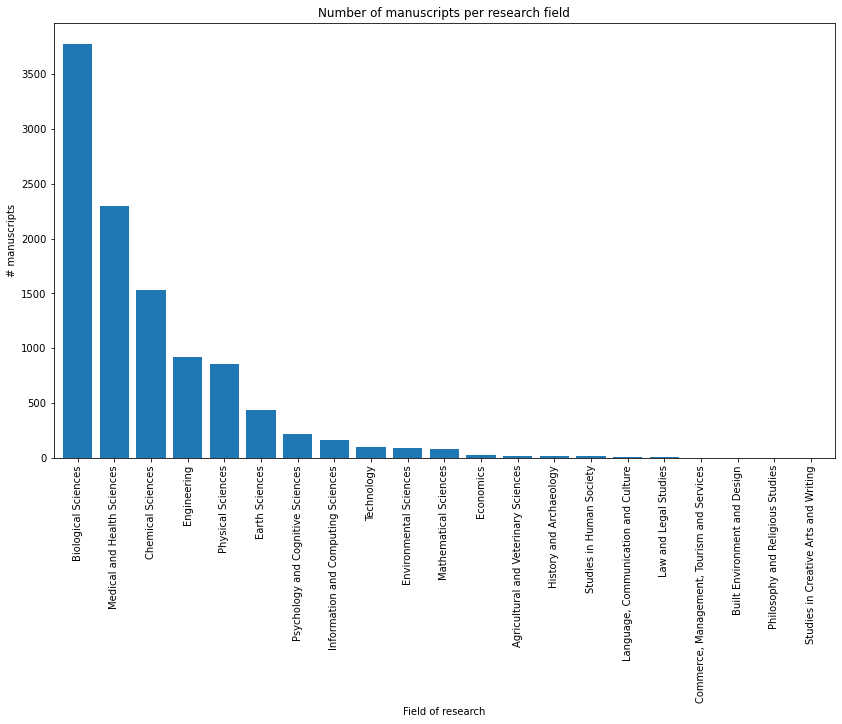

In [15]:
# check class distribution
for_counts = df_clean['for_name'].value_counts()
for_unique = df_clean['for_name'].nunique()
print(for_counts)
print(for_unique)

width = 0.8

fig, ax = plt.subplots(figsize=(14, 8))
df_clean['for_name'].value_counts().plot(kind="bar", ax=ax, width=width)
plt.ylabel('# manuscripts')
plt.xlabel('Field of research')
plt.title('Number of manuscripts per research field')
plt.show()

There is an imbalanced class distribution within the dataset, which is heavily skewed towards Biological Sciences, Medical and Health Sciences and Chemical Sciences. There are 6 fields of research that have less than 10 associated manuscripts.

This class imbalance will need to be addressed to prevent the model from overfitting to the majority/dominant classes. The classes that are less common are treated as noise and often ignored. This means that there will be a higher misclassification rate for the minority classes as the majority classes will dominate.

It is also important to be aware of this problem whilst selecting an appropriate metric for measuring model performance. Using accuracy (proportion of correct predictions) is not a good metric for imbalanced datasets, as this metric will not reflect the model's performance of the minority classes. E.g. Based on the x class domination, a machine learning algorithm could simply classify everything as x class and still be correct 80% of the time.

Hence we will try a few different approaches for resolving the class imbalance distribution during the feature engineering and modelling phases.

In [16]:
#  for now, the classes with less than 10 associated articles will be removed to initially train the model.
#  other methods for dealing with underrepresented classes can be dealt with at a later date.

for_under10 = for_counts[for_counts >= 10].index.tolist()
df = df_clean[df_clean['for_name'].isin(for_under10)]

print(len(df_clean) - len(df))
print(len(df))
df['for_name'].value_counts()

65
10573


Biological Sciences                     3775
Medical and Health Sciences             2300
Chemical Sciences                       1534
Engineering                              923
Physical Sciences                        854
Earth Sciences                           441
Psychology and Cognitive Sciences        217
Information and Computing Sciences       169
Technology                               100
Environmental Sciences                    92
Mathematical Sciences                     86
Economics                                 29
Agricultural and Veterinary Sciences      18
History and Archaeology                   18
Studies in Human Society                  17
Name: for_name, dtype: int64

There are now 10,573 articles in the dataset, all of which belong to a category that has 10 or more associated articles. 65 articles were removed from the dataset as they belonged to underrepresented categories (less than 10).

In [17]:
print(df.groupby('for_name')['n_references'].mean().sort_values(ascending=False))

for_name
Biological Sciences                     58.396556
Psychology and Cognitive Sciences       58.364055
Earth Sciences                          57.789116
Medical and Health Sciences             57.323913
Environmental Sciences                  55.032609
History and Archaeology                 51.722222
Chemical Sciences                       50.774446
Agricultural and Veterinary Sciences    49.777778
Economics                               49.379310
Technology                              47.810000
Mathematical Sciences                   47.209302
Engineering                             46.677140
Physical Sciences                       45.756440
Information and Computing Sciences      45.112426
Studies in Human Society                32.058824
Name: n_references, dtype: float64


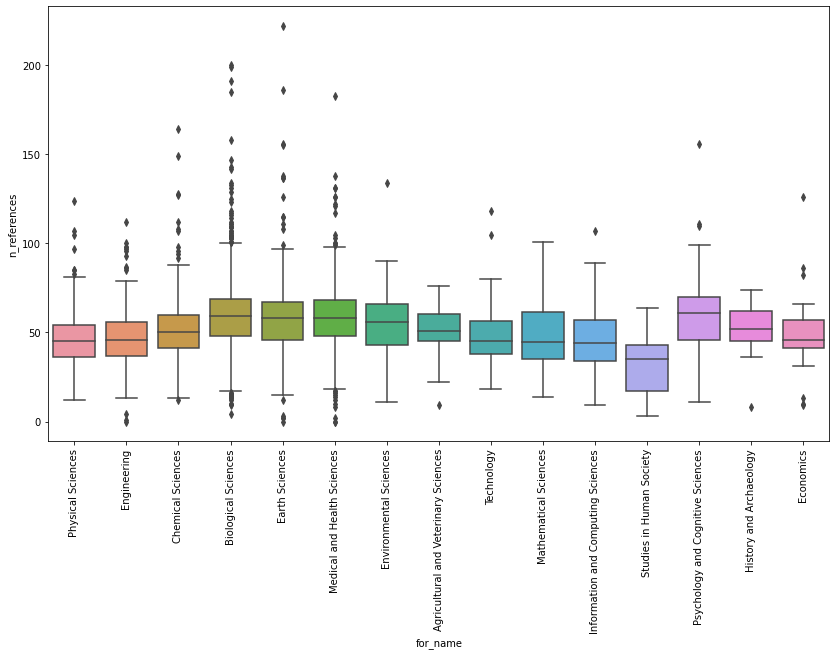

In [18]:
#  visualising n_references field per field of research (how many articles each manuscript reference)
fig, ax = plt.subplots(figsize=(14,8))
sns.boxplot(x='for_name', y='n_references', data=df, ax=ax)
plt.xticks(rotation=90)
plt.show()

In [19]:
# for now we will drop all columns except the title (features) and target variable (for)

df = df.drop(['n_references'], axis=1)

### 4. Text pre-processing

The purpose of this stage is to make the data readable by a machine learning algorithm. Algorithms cannot understand words. Instead, words need to be converted into numbers, otherwise known as 'vectors'. To do this, sentences first must be cleansed by removing punctuation/special characters as these will act as noise in the data and will not be indicative of the target class you are trying to predict. For example, the presence of a colon or a question mark are not going to be indicative of the craft type, hence they will not be useful predictors and can be removed.

We also need to reduce the word to their root form to remove all similar instances of a word which will also reduce noise in the dataset and the number of features in the dataset. We will do this through lemmatization, which gets its name from 'lemma', which is the root form of a word. E.g. transformed 'sailing' and 'sailed' to 'sail'.

We will first focus on the text cleansing phase, and then on the vectorisation phase.

#### Text cleansing

In [20]:
#  exploring patterns in the titles to assess how best to cleanse the data

pat = '\:|-|\+'
pat_list = [r'\d', '-', '\+', ':', '!', '\?', '\.'] # list of special characters/punctuation to search for in data

punc_total = df['title'].str.contains(pat).sum()
punc_df = df[df['title'].str.contains('\.')]

pat_list = [r'\d', '-', '\+', ':', '!', '\?', '\.'] # list of special characters/punctuation to search for in data

def punc_search(df, col, pat):
    """
    function that counts the number of articles
    that contain a pre-defined list of special
    characters and punctuation
    
    """
    for p in pat:
        v = df[col].str.contains(p).sum() # total n_rows that contain the pattern
        print(f'{p} special character is present in {v} articles')

punc_search(df, 'title', pat_list)

\d special character is present in 2723 articles
- special character is present in 5621 articles
\+ special character is present in 150 articles
: special character is present in 35 articles
! special character is present in 0 articles
\? special character is present in 4 articles
\. special character is present in 115 articles


Options for cleansing text data:

Lower case, space delimiter plus:

- option 1 - remove all special characters including hyphens and replace with space, do not remove numbers 
- option 2 - remove all special characters excluding hyphens, do not remove numbers
- option 3 - option 1 or 2 but remove numbers

I will play around with removing numbers as this may affect model performance as numbers are used in chemical compound naming. 

In [21]:
#test = df.sample(100, random_state=23)
#print(test)

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def text_cleanse_1(df, col):
    """
    cleanses text by removing special
    characters and lemmatizing each
    word
    
    """
    df[col] = df[col].str.lower()  # convert text to lowercase
    df[col] = df[col].str.replace(r'-','', regex=True) # remove hyphens
    df[col] = df[col].str.replace(r'\d','', regex=True) # remove numbers 
    df[col] = df[col].str.replace(r'\W','', regex=True)  # remove special characters
    df[col] = df[col].str.replace(r'\s+[a-zA-Z]\s+',' ', regex=True) # remove single characters
    df[col] = df.apply(lambda x: nltk.word_tokenize(x[col]), axis=1) # tokenise titles ready for applying lemmatisation
    df[col] = df[col].apply(lambda x:[lemmatizer.lemmatize(word) for word in x]) # lemmatise words
    df[col] = df[col].apply(lambda x : " ".join(x)) # de-tokenise titles ready for vectorisation

    #lemmatizer.lemmatize(stemmer.stem(word))
    #df[col] = df[col].apply(lambda x:[lemmatizer.lemmatize(word) for word in x]) # lemmatise words
    
text_cleanse_1(df,'title')
punc_search(df, 'title', pat_list)

df


\d special character is present in 0 articles
- special character is present in 0 articles
\+ special character is present in 0 articles
: special character is present in 0 articles
! special character is present in 0 articles
\? special character is present in 0 articles
\. special character is present in 0 articles


,title,doc_id,for_name,for_code
0,surface acoustic wave photonic device in silicon on insulator,10.1038/s41467-019-12157-x,Physical Sciences,2.0
1,thermal and electrical signature of hydrodynamic electron fluid in tungsten diphosphide,10.1038/s41467-018-06688-y,Engineering,9.0
2,phononic integrated circuitry and spin orbit interaction of phonons,10.1038/s41467-019-10852-3,Physical Sciences,2.0
3,local josephson vortex generation and manipulation with magnetic force microscope,10.1038/s41467-019-11924-0,Physical Sciences,2.0
4,a robust zirconium amino acid metalorganic framework for proton conduction,10.1038/s41467-018-07414-4,Chemical Sciences,3.0
...,...,...,...,...
11342,apkc control endothelial growth by modulating cmyc via foxo dnabinding ability,10.1038/s41467-018-07739-0,Biological Sciences,6.0
11343,single goldbridged nanoprobes for identification of single point dna mutation,10.1038/s41467-019-08769-y,Chemical Sciences,3.0
11344,conditional expression explains molecular evolution of social gene in microbe,10.1038/s41467-019-11237-2,Biological Sciences,6.0
11345,genetic study link component of the autonomous nervous system to heartrate profile during exercise,10.1038/s41467-018-03395-6,Biological Sciences,6.0


In [22]:
# finally, as we removed some of the research categories, we need to create new labels out of the remaining categories

label_encoder = preprocessing.LabelEncoder() # initiate label encoder object
df_new = df.copy()
df_new['target'] = label_encoder.fit_transform(df_new['for_name'])
  
df_new[['for_name','target']].value_counts().sort_index(ascending=True)

for_name                              target
Agricultural and Veterinary Sciences  0           18
Biological Sciences                   1         3775
Chemical Sciences                     2         1534
Earth Sciences                        3          441
Economics                             4           29
Engineering                           5          923
Environmental Sciences                6           92
History and Archaeology               7           18
Information and Computing Sciences    8          169
Mathematical Sciences                 9           86
Medical and Health Sciences           10        2300
Physical Sciences                     11         854
Psychology and Cognitive Sciences     12         217
Studies in Human Society              13          17
Technology                            14         100
dtype: int64

#### Text vectorisation

The process of converting text data into numerical data or 'vectors' is called vectorization. Machine learning models cannot understand words, so these must be converted to numeric values. There are two methods for vectorising, the Bag of Words methods and Word Embedding methods. The difference between the two is that word sequence is considered in the latter, where semantically similar words are grouped together. I will be using the Bag of words method, specifically the TFIDF (term frequency inverse document frequency) vector in this analysis to begin with.

Each unique word in the dataset will correspond to a feature, where each feature will have an integer associated depending on how many times that word appears in the text (a Word Count Vector - sklearn's CountVectorizer) or a weighted integer that indicates the importance of the word in the text (a TF-IDF Vector - sklearn's TfidVectorizer). The TF-IDF value for a word in a particular narrative is higher if the frequency of occurrence of that word is higher in narratives belonging to that specific craft type and lower in narratives of other craft types. As such, the weights of common words that appear in all narratives, irrespective of craft type, will be reduced. The TF-IDF is calculated by multiplying the term frequency of a word by the inverse document frequency. 

Just because a word appears multiple times in a text does not mean that it is a good identifier of that narrative's craft type, as the same word could feature heavily in other target classes too (e.g. the words 'study', 'science', 'research', 'experiment' may be frequent, but aren't indicative of the field of research).

The following procedures will be completed:
- Vectorization - using TF-IDF vectorizer, which accepts non-tokenised data. The parameters of the vectorisation process can be adjusted to allow for the following:
    - Data will be tokenised into word tokens during this process.
    - Remove stopwords (e.g. a, the, that) using corpus from nltk library (sentences must be tokenised prior to stop word removal). By removing stopword tokens or 'noise', only the tokens that are useful or those that contain important information will remain. Stopword removal  will also decrease the size of the feature dataset which hence will aid efficiency.

In [33]:
stop_words = set(nltk.corpus.stopwords.words('english')) # using nltk stopword corpus as there are reported issues with sklearn stopword corpus. else sklearn parameter =  stop_words = stopwords.words('english')

vectorizer = TfidfVectorizer(stop_words=stop_words,max_df=0.7) # initialising the tfidf vectorizer

# The stop words will be removed, and only words within a maximum of 70% of the documents will be retained. Else they are deemed too common to be useful in differentiating between documents.
# arg  'ngram_range=(n,n)'
# arg 'sublinear_tf=True', takes the log of the tf-idf, see https://nlp.stanford.edu/IR-book/html/htmledition/sublinear-tf-scaling-1.html 

In [34]:
# inspecting the vectors
#print(tfidf_vectorizer.get_feature_names()[100:120])

# Print n vectors of the tfidf training data
#print(tfidf_train[55:70])

### 5. Model Selection

<strong>Cross_validate</strong> is a function from the scikit-learn library which allows you to iteratively train and validate the model on different splits or folds of your data with the aim of better understanding the performance of a model. Taking one metric as gospel from one particular fold may not be accurate given that the data are split randomly. It is very similar to sklearn's cross_val_score except you can pass in multiple model performance metrics.

I will iteratively test 4 classification models (Multinomial NB, Mulitnomial Logistic Regression, Linear SVM and Random Forest) using the cross validation score method and then pick the best model to fine tune.

In [23]:
models = [RandomForestClassifier(n_estimators = 100, max_depth=5, random_state=42), 
          LinearSVC(random_state=42),
          MultinomialNB(), 
          LogisticRegression(random_state=42)]

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1) # With StratifiedKFold, the folds are made by preserving the percentage of samples for each class.

scoring = ['accuracy', 'f1_macro', 'recall_macro', 'precision_macro']

### Train test split

Transformations are only to be performed on the training data. The test data will be held for testing of each different model to allow comparison.

In [35]:
# create train and test data split
X_train, X_test, y_train, y_test = train_test_split(df_new['title'], # features
                                                    df_new['target'], # target
                                                    test_size=0.3, # 70% train, 30% test
                                                    random_state=42, # ensures same split each time to allow repeatability
                                                    shuffle = True, # shuffles data prior to splitting
                                                    stratify = df_new['target']) # distribution of classes across train and test

In [36]:
#  vectorising the train and test feature data
X_train_vector = vectorizer.fit_transform(X_train).toarray()

# Transform the test data using the same dictionary as the train data 
X_test_vector = vectorizer.transform(X_test).toarray()

In [27]:
import warnings 
warnings.filterwarnings("ignore") # to remove 'zero division' warnings for metrics. This occurs when there are classes with no predicted labels which we can see in the confusion matrix. 
# For the purpose of neatening the notebook for audit.

In [28]:
for model in tqdm(models):
    model_name = model.__class__.__name__
    result = cross_validate(model, X_train_vector, y_train, cv=kf, scoring=scoring)
    print("%s: Mean Accuracy = %.2f%%; Mean F1-macro = %.2f%%; Mean recall-macro = %.2f%%; Mean precision-macro = %.2f%%" 
          % (model_name, 
             result['test_accuracy'].mean()*100, 
             result['test_f1_macro'].mean()*100, 
             result['test_recall_macro'].mean()*100, 
             result['test_precision_macro'].mean()*100))

  0%|          | 0/4 [00:00<?, ?it/s]

RandomForestClassifier: Mean Accuracy = 35.70%; Mean F1-macro = 3.51%; Mean recall-macro = 6.67%; Mean precision-macro = 2.38%
LinearSVC: Mean Accuracy = 67.71%; Mean F1-macro = 35.88%; Mean recall-macro = 33.10%; Mean precision-macro = 45.04%
MultinomialNB: Mean Accuracy = 56.41%; Mean F1-macro = 16.82%; Mean recall-macro = 16.37%; Mean precision-macro = 29.62%
LogisticRegression: Mean Accuracy = 63.19%; Mean F1-macro = 23.38%; Mean recall-macro = 21.96%; Mean precision-macro = 33.11%


From the 4 classification models above, the best performing was the Linear SVC (Support Vector Classifier), so I will now fine tune this model to see if the model performance can be improved.

Of note are the differences between the F1-macro and F1-weighted scores. The F1 score is an average of precision and recall for each class. It is a good metric to use instead of accuracy for an imbalanced dataset. The F1-macro score averages the F1 scores for all classes equally, it is an 'unweighted mean' of all the per-class F1 scores. The weighted score adds weight to classes that have a higher number of data points in the dataset, it is the 'weighted mean'. The takeaway from the F1 scores, given the lower F1-macro compared to the F1-weighted suggests that the model was performing to a 'good' level with ubiquitous classes but poorly on underrepresented classes, which is what is to be expected.



### 6. Baseline model performance

I will run the baseline LinearSVC model here to report the metrics before hyperparameter tuning or fixing the imbalanced class distribution. We can compare each iteration of attempted model performance improvement to this baseline. 

Again, to ensure that the same folds of data are tested each time to allow for repeatability, I will use a StratifiedKFold object (instead of cv=5). With StratifiedKFold, the folds are made by preserving the percentage of samples for each class.

In [37]:
#  fold parameter for gridsearch/cross_validate
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1) 

# defining list of parameters for LinearSVM for GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

In [35]:
print("Each of the %d research articles is represented by %d features (TF-IDF score of unigrams)" %(X_train_vector.shape))

Each of the 7401 research articles is represented by 14940 features (TF-IDF score of unigrams)


In [38]:
# initialise baseline classifier
svc_baseline = LinearSVC(random_state=42)

#  printing list of hyperparameters for linear SVC
print(svc_baseline.get_params().keys())

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'loss', 'max_iter', 'multi_class', 'penalty', 'random_state', 'tol', 'verbose'])


In [39]:
# metrics to measure
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'f1_weighted']

#  metrics before hyperparameter tuning
result = cross_validate(svc_baseline, X_train_vector, y_train, cv=kf, scoring=scoring)
print("Validation set metrics: Mean Accuracy = %.2f%%; Mean Precision = %.2f%%; Mean Recall = %.2f%%; Mean F1-macro = %.2f%%; Mean F1-weighted = %.2f%%" 
        % (result['test_accuracy'].mean()*100, 
            result['test_precision_macro'].mean()*100,
            result['test_recall_macro'].mean()*100,
            result['test_f1_macro'].mean()*100, 
            result['test_f1_weighted'].mean()*100))

Validation set metrics: Mean Accuracy = 67.71%; Mean Precision = 45.04%; Mean Recall = 33.10%; Mean F1-macro = 35.88%; Mean F1-weighted = 66.12%


Let's use GridSearch to optimise the model by tuning hyperparameters, and then fit the tuned model to the training data

In [43]:
# grid search to select hyperparameters to optimise model. you can cross-validate with grid-search
svc_baseline_cv = GridSearchCV(svc_baseline, 
                               param_grid = param_grid, 
                               cv=kf, 
                               scoring='f1_macro').fit(X_train_vector, y_train)

svc_baseline_cv.best_score_  # this returns the scoring metric specified above

0.36104229187799697

In [56]:
#  function to predict on test data using i model iteration and compute metrics

def model_pred_metrics(model, X=X_test_vector, average='macro'):
    
    """
    Function to test model on test data
    Outputs metrics, classification report
    and confusion matrix
    
    Tests on vectorized X test data
    
    Averages of the metrics are set to 
    'macro' to get weighted metrics due
    to imbalanced nature of data
    
    """
    
    pred = model.predict(X_test_vector)
    
    accuracy = metrics.accuracy_score(y_test, pred)
    precision = metrics.precision_score(y_test, pred, average=average)
    recall = metrics.recall_score(y_test, pred, average=average)
    f1 = metrics.f1_score(y_test, pred, average=average)
    cm = metrics.confusion_matrix(y_test, pred)
    
    #print(Counter(y_train))
    
    print('Accuracy: %.2f%%' % (accuracy*100))
    print('Precision: %.2f%%' % (precision*100))
    print('Recall: %.2f%%' % (recall*100))
    print('F1: %.2f%%' % (f1*100))
    print(metrics.classification_report(y_test, pred))
  
    # plotting confusion matrix
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 

Accuracy: 66.77%
Precision: 44.88%
Recall: 36.63%
F1: 39.32%
              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.72      0.81      0.76      1133
           2       0.67      0.66      0.66       460
           3       0.80      0.77      0.78       132
           4       0.00      0.00      0.00         9
           5       0.50      0.51      0.50       277
           6       0.56      0.32      0.41        28
           7       0.00      0.00      0.00         5
           8       0.38      0.16      0.22        51
           9       0.28      0.19      0.23        26
          10       0.68      0.66      0.67       690
          11       0.58      0.57      0.58       256
          12       0.60      0.42      0.49        65
          13       0.33      0.20      0.25         5
          14       0.12      0.03      0.05        30

    accuracy                           0.67      3172
   macro avg       

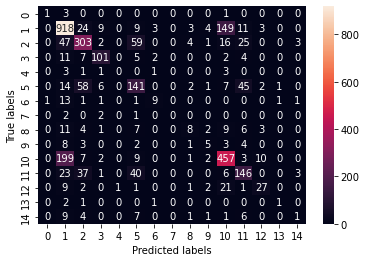

In [42]:
model_pred_metrics(svc_baseline_cv)

These are our scores to beat... the difference between these scores helps you understand degree of overfitting. 

>F1 gridsearch:  0.36

>F1 gridsearch test: 0.39

Even with hyper-parameter tuning, there is still an issue with performance in the underrepresented classes. Precision is generally better than recall, inferring that the model is better at labelling positive predictions correctly over capturing all positive labels (i.e. has a high rate of false negatives).

### 7. Model improvement iterations

### Model improvement #1 - adding class weights

The class weights parameter allows you to add a penalty function based on the class distribution, giving a higher weight to minority classes for misclassification.

'It means the model is more likely to guess that class when it's making predictions, which will generally increase recall (how many of the true examples of that class are we guessing) while decreasing precision (how often are we right when we guess that class)'

In [44]:
svc_balanced = LinearSVC(class_weight='balanced', random_state=42)  # weights minority classes to penalise for misclassification

In [45]:
# grid search to select hyperparameters to optimise model. you can cross-validate with grid-search
svc_balanced_cv = GridSearchCV(svc_balanced, 
                               param_grid = param_grid, 
                               cv=kf, 
                               scoring='f1_macro').fit(X_train_vector, y_train)  # need to select metric, is recall the best one

svc_balanced_cv.best_score_  # this returns the scoring metric specified above

0.408710046490563

Accuracy: 67.47%
Precision: 39.27%
Recall: 48.76%
F1: 42.25%
              precision    recall  f1-score   support

           0       0.22      0.40      0.29         5
           1       0.80      0.75      0.77      1133
           2       0.74      0.67      0.70       460
           3       0.65      0.85      0.73       132
           4       0.15      0.22      0.18         9
           5       0.60      0.49      0.54       277
           6       0.33      0.75      0.46        28
           7       0.00      0.00      0.00         5
           8       0.26      0.39      0.31        51
           9       0.14      0.31      0.19        26
          10       0.75      0.66      0.70       690
          11       0.62      0.67      0.65       256
          12       0.44      0.72      0.55        65
          13       0.08      0.20      0.12         5
          14       0.11      0.23      0.15        30

    accuracy                           0.67      3172
   macro avg       

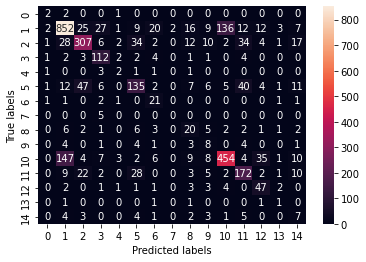

In [46]:
model_pred_metrics(svc_balanced_cv)

### Model improvement #1.5 - manually adjusting class weights

By manually adjusting class weights, you can balance precision and recall for each class. I will base the weightings on the metric of choice from the classification report above, adding weight to those that are underperforming.

Note that if you improve recall, precision will by default, decrease. When we increase the weight for one class, we are effectively relatively decreasing the weight for all other classes. Hence:

Increase class weight = increased recall = decreased precision

As I'm trying to improve the F1 score, I will iteratively adjust the weights until precision and recall are roughly balanced for each class.

In [50]:
class_weights_v1 = {
    0:4,
    1:1,
    2:1,
    3:1,
    4:4,
    5:2,
    6:2,
    7:4,
    8:2,
    9:3,
    10:1,
    11:1,
    12:2,
    13:3,
    14:3,
}

In [51]:
svc_balanced_man_v1 = LinearSVC(class_weight=class_weights_v1, random_state=42)  # weights minority classes to penalise for misclassification

In [52]:
# grid search to select hyperparameters to optimise model. you can cross-validate with grid-search
svc_balanced_man_cv_v1 = GridSearchCV(svc_balanced_man_v1, 
                               param_grid = param_grid, 
                               cv=kf, 
                               scoring='f1_macro',
                               return_train_score=True).fit(X_train_vector, y_train)

svc_balanced_man_cv_v1.best_score_  # this returns the scoring metric specified above

0.3784850183498552

Accuracy: 68.69%
Precision: 51.81%
Recall: 39.32%
F1: 43.09%
              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.72      0.84      0.78      1133
           2       0.72      0.67      0.70       460
           3       0.79      0.76      0.78       132
           4       0.50      0.11      0.18         9
           5       0.50      0.54      0.52       277
           6       0.69      0.39      0.50        28
           7       0.00      0.00      0.00         5
           8       0.48      0.22      0.30        51
           9       0.30      0.23      0.26        26
          10       0.71      0.67      0.69       690
          11       0.64      0.58      0.61       256
          12       0.64      0.38      0.48        65
          13       0.33      0.20      0.25         5
          14       0.25      0.10      0.14        30

    accuracy                           0.69      3172
   macro avg       

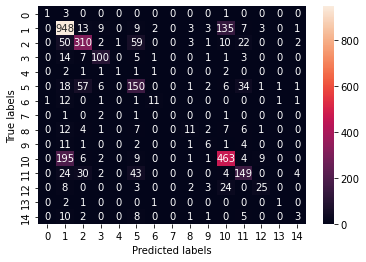

In [51]:
model_pred_metrics(svc_balanced_man_cv_v1)

In [53]:
#  training and test scores to assess model overfitting to training data
print(svc_balanced_man_cv_v1.cv_results_["mean_train_score"])
print(svc_balanced_man_cv_v1.cv_results_["mean_test_score"])

[0.03507584 0.08682746 0.89353791 0.9986052  1.         1.        ]
[0.03507583 0.06813973 0.31592256 0.37848502 0.36073921 0.3567624 ]


Let's make some further tweaks to weight the still under performing classes

In [52]:
class_weights_v2 = {
    0:4,
    1:1,
    2:1,
    3:1,
    4:5,
    5:2,
    6:2,
    7:5,
    8:2,
    9:3,
    10:1,
    11:1,
    12:2,
    13:3,
    14:4,
}

In [53]:
svc_balanced_man_v2 = LinearSVC(class_weight=class_weights_v2, random_state=42)  # weights minority classes to penalise for misclassification

In [54]:
# grid search to select hyperparameters to optimise model. you can cross-validate with grid-search
svc_balanced_man_cv_v2 = GridSearchCV(svc_balanced_man_v2, 
                               param_grid = param_grid, 
                               cv=kf, 
                               scoring='f1_macro').fit(X_train_vector, y_train)  # need to select metric, is recall the best one

svc_balanced_man_cv_v2.best_score_  # this returns the scoring metric specified above

0.3783498367423944

Accuracy: 68.63%
Precision: 51.40%
Recall: 39.28%
F1: 42.99%
              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.72      0.84      0.78      1133
           2       0.72      0.67      0.69       460
           3       0.79      0.76      0.78       132
           4       0.50      0.11      0.18         9
           5       0.50      0.54      0.52       277
           6       0.69      0.39      0.50        28
           7       0.00      0.00      0.00         5
           8       0.48      0.22      0.30        51
           9       0.30      0.23      0.26        26
          10       0.71      0.67      0.69       690
          11       0.64      0.58      0.61       256
          12       0.64      0.38      0.48        65
          13       0.33      0.20      0.25         5
          14       0.19      0.10      0.13        30

    accuracy                           0.69      3172
   macro avg       

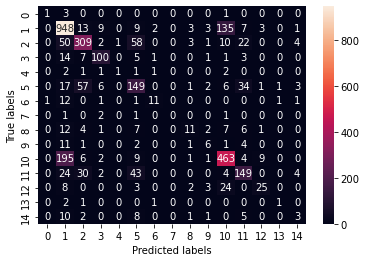

In [55]:
model_pred_metrics(svc_balanced_man_cv_v2)

### Model improvement #2 - random oversampling minority classes

Random oversampling involves randomly duplicating examples from the minority class and adding them to the training dataset. To artificially resolve imbalanced class distribution problem, I will use the python library imblearn that oversamples minority classes to create equal class distribution. Oversampling is only applied to the training dataset and used to fit the model.

As new data points are not being generated (the same data points are being sampled), this can lead to overfitting which may pose a limitation.

I will use a pipeline now to conduct all the transformations so that the validation portion of the data in the gridsearch is not oversampled, only the training folds.

In [54]:
over_pipe = Pipeline([('RandomOverSample', RandomOverSampler(random_state=42)), 
                          ('LinearSVC', LinearSVC(random_state=42))])

new_params = {"LinearSVC__C": [0.001, 0.01, 0.1, 1, 10, 100]}


svc_oversample_cv = GridSearchCV(over_pipe, 
                                param_grid = new_params, 
                                cv=kf, 
                                scoring='f1_macro',
                                return_train_score=True).fit(X_train_vector, y_train)  # need to select metric, is recall the best one

svc_oversample_cv.best_score_  # this returns the scoring metric specified above

C:\Users\lucy_dickinson\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\lucy_dickinson\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\lucy_dickinson\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\lucy_dickinson\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\lucy_dickinson\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.409732915184532

Accuracy: 68.44%
Precision: 45.01%
Recall: 46.90%
F1: 44.79%
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.80      0.75      0.78      1133
           2       0.75      0.67      0.71       460
           3       0.65      0.83      0.73       132
           4       0.33      0.11      0.17         9
           5       0.53      0.51      0.52       277
           6       0.40      0.64      0.49        28
           7       0.00      0.00      0.00         5
           8       0.26      0.33      0.29        51
           9       0.17      0.31      0.22        26
          10       0.72      0.71      0.71       690
          11       0.61      0.67      0.64       256
          12       0.49      0.66      0.56        65
          13       0.20      0.20      0.20         5
          14       0.17      0.23      0.19        30

    accuracy                           0.68      3172
   macro avg       

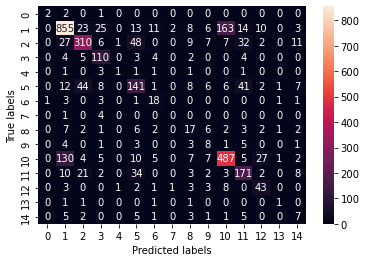

In [57]:
model_pred_metrics(svc_oversample_cv)

In [58]:
#  training and test scores to assess model overfitting to training data
print(svc_oversample_cv.cv_results_["mean_train_score"])
print(svc_oversample_cv.cv_results_["mean_test_score"])

[0.51964058 0.69876803 0.93740942 0.99893465 1.         1.        ]
[0.33984301 0.38352422 0.40973292 0.37891587 0.35979185 0.35619813]


The best F1 macro score so far at 0.449. The minority classes are still bringing the F1 average down.

### Model improvement #3 - SMOTE oversampling minority classes

Stands for Synthetic Minority Oversampling Technique. Synthetically generates new data based upon existing data. Could pose advantageous over random oversampling as new data is being generated with SMOTE.

Again, I will use a pipeline to apply the sampling method when using cross validation.

In [63]:
smote_pipe = Pipeline([('SMOTE', SMOTE(random_state=42)), 
                          ('LinearSVC', LinearSVC(random_state=42))])

new_params = {"LinearSVC__C": [0.001, 0.01, 0.1, 1, 10, 100]}


svc_smote_cv = GridSearchCV(smote_pipe, 
                            param_grid = new_params, 
                            cv=kf, 
                            scoring='precision_macro').fit(X_train_vector, y_train)  # need to select metric, is recall the best one

svc_smote_cv.best_score_  # this returns the scoring metric specified above

0.4261846383597188

Accuracy: 68.06%
Precision: 51.25%
Recall: 40.67%
F1: 42.80%
              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.76      0.80      0.77      1133
           2       0.70      0.67      0.68       460
           3       0.72      0.80      0.76       132
           4       1.00      0.11      0.20         9
           5       0.49      0.53      0.51       277
           6       0.50      0.46      0.48        28
           7       0.00      0.00      0.00         5
           8       0.31      0.18      0.23        51
           9       0.27      0.23      0.25        26
          10       0.71      0.70      0.70       690
          11       0.58      0.60      0.59       256
          12       0.60      0.51      0.55        65
          13       0.33      0.20      0.25         5
          14       0.21      0.13      0.16        30

    accuracy                           0.68      3172
   macro avg       

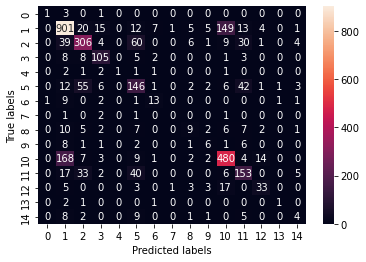

In [64]:
model_pred_metrics(svc_smote_cv)

### Model improvement #4 - oversampling/undersampling combination

The original paper on SMOTE suggested combining SMOTE with random undersampling of the majority class. We will oversample the minority class to have 10 percent the number of examples of the majority class, then use random undersampling to reduce the number of examples in the majority class to have 50 percent more than the minority class.

In [65]:
over = SMOTE(random_state=42)
under = RandomUnderSampler(random_state=42)

In [66]:
over_under_pipe = Pipeline([('over', over), #  using a pipeline so sampling is only conducted on training data, not validation or test
                           ('under', under),
                            ('LinearSVC', LinearSVC(random_state=42))])

new_params = {"LinearSVC__C": [0.001, 0.01, 0.1, 1, 10, 100]}


svc_over_under_cv = GridSearchCV(over_under_pipe, 
                                param_grid = new_params, 
                                cv=kf, 
                                scoring='f1_macro').fit(X_train_vector, y_train) 

svc_over_under_cv.best_score_  # this returns the scoring metric specified above

0.48151585862633395

Accuracy: 62.17%
Precision: 35.88%
Recall: 48.30%
F1: 38.65%
              precision    recall  f1-score   support

           0       0.09      0.40      0.14         5
           1       0.82      0.61      0.70      1133
           2       0.74      0.63      0.68       460
           3       0.67      0.80      0.73       132
           4       0.07      0.22      0.11         9
           5       0.56      0.49      0.52       277
           6       0.31      0.68      0.42        28
           7       0.08      0.20      0.11         5
           8       0.19      0.37      0.25        51
           9       0.13      0.42      0.20        26
          10       0.67      0.69      0.68       690
          11       0.62      0.63      0.62       256
          12       0.30      0.66      0.41        65
          13       0.06      0.20      0.09         5
          14       0.08      0.23      0.11        30

    accuracy                           0.62      3172
   macro avg       

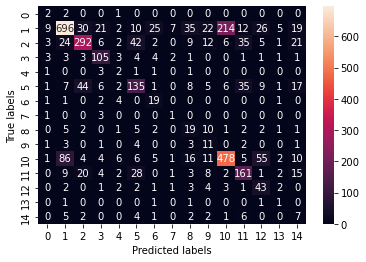

In [67]:
model_pred_metrics(svc_over_under_cv)

### Model improvement #5 - data augmentation with wordnet

New data can be generated using synonyms of existing data to increase the number of data points for minority classes. Augmentation techniques include synonym replacement (which I will try below) and back translation (translating into one langauge and back to the original language). 

Only augmented on training data (not cross-val) so will need to put in a pipeline.

In [38]:
# create wordnet augmenter object
aug = naw.SynonymAug(aug_src='wordnet',aug_max=4) # replace a max of 4 words per sentence. This number can be tweaked.

In [39]:
# example of augmenter generating 2 new sentences
aug.augment("genetic study link component of the autonomous nervous system to heart rate profile during exercise", n=2)

['genic survey colligate component of the autonomous nervous system of rules to heart rate profile during exercise',
 'genetic field link up component of the autonomous unquiet system to tenderness rate profile during exercise']

In [40]:
# create empty lists to store new data

augmented_sentences=[]
augmented_sentences_labels=[]

# for loop to create n copies of each manuscript title belonging to y class

for i in tqdm(X_train.index):
  if y_train[i]==13 or y_train[i]==0 or y_train[i]==7 or y_train[i]==4 or y_train[i]==9 or y_train[i]==6: # if the class ==x, then do the following
    temps=aug.augment(X_train[i],n=10) # create 10 copies of the sentence
    label = y_train[i]
    for i in temps:
       augmented_sentences.append(i)
       augmented_sentences_labels.append(label)
  elif y_train[i]==14 or y_train[i]==8 or y_train[i]==12 or y_train[i]==3 or y_train[i]==11 or y_train[i]==5:
    temps=aug.augment(X_train[i],n=4) # create 4 copies of the sentence
    label = y_train[i]
    for i in temps:
        augmented_sentences.append(i)
        augmented_sentences_labels.append(label)

  0%|          | 0/7401 [00:00<?, ?it/s]

In [41]:
augmented_sentences

['vapor sublimation and deposition to build porous atom and composite',
 'vapor sublimation and deposition to progress porous subatomic particle and composite',
 'vapor sublimation and dethronement to work up porous particle and composite',
 'vapor sublimation and deposition to build holey particle and composite',
 'unmasking chloride attack on the peaceful film of metallic element',
 'unmasking chloride attack on the passive film of metallic element',
 'unmasking chloride flak on the passive motion picture of metal',
 'unmask chloride plan of attack on the passive cinema of metal',
 'dyke intrusion between neighbour arc volcano responsible for for preeruptive seismic horde at agung',
 'dyke intrusion between neighbouring arc volcano responsible for preeruptive seismic cloud at agung',
 'dyke intrusion between neighbouring arc vent responsible for preeruptive seismic cloud at agung',
 'dyke intrusion between neighbouring arc vent responsible for preeruptive seismic swarm at agung',
 's

In [42]:
print('We have generated', len(augmented_sentences_labels), 'new rows of data through text augmentation')

We have generated 9392 new rows of data through text augmentation


In [43]:
#  appending new data onto training data
X_train_aug = X_train.append(pd.Series(augmented_sentences),ignore_index=True)
y_train_aug = y_train.append(pd.Series(augmented_sentences_labels),ignore_index=True)

print(X_train.shape)
print(y_train.shape)
print(X_train_aug.shape)
print(y_train_aug.shape)

(7401,)
(7401,)
(16793,)
(16793,)


In [44]:
# new value counts of classes
y_train_aug.value_counts()

5     3230
11    2990
1     2642
10    1610
3     1545
2     1074
12     760
6      704
9      660
8      590
14     350
4      220
7      143
0      143
13     132
dtype: int64

Now to vectorize and model the data to see if there are any improvements to the metrics!

In [45]:
#  vectorising the train feature data 
X_train_vector_aug = vectorizer.fit_transform(X_train_aug).toarray()

# Transform the test data using the same dictionary as the train data 
X_test_vector_aug = vectorizer.transform(X_test).toarray()

In [46]:
# initialising classifier with balanced class_weights
svc_aug = LinearSVC(class_weight='balanced', C=1)  # weights minority classes to penalise for misclassification

Accuracy: 68.76%
Precision: 42.41%
Recall: 42.46%
F1: 42.15%
              precision    recall  f1-score   support

           0       0.33      0.20      0.25         5
           1       0.78      0.79      0.78      1133
           2       0.73      0.67      0.70       460
           3       0.69      0.82      0.75       132
           4       0.00      0.00      0.00         9
           5       0.52      0.55      0.53       277
           6       0.44      0.50      0.47        28
           7       0.00      0.00      0.00         5
           8       0.34      0.27      0.30        51
           9       0.23      0.31      0.26        26
          10       0.72      0.69      0.71       690
          11       0.58      0.62      0.60       256
          12       0.54      0.58      0.56        65
          13       0.25      0.20      0.22         5
          14       0.21      0.17      0.19        30

    accuracy                           0.69      3172
   macro avg       

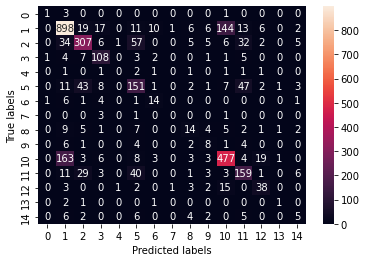

In [49]:
# manual train test split and model implementation as I need to build a pipeline to include augmenter function to use 
# cross validation

# fit the classifier to the training data
svc_aug.fit(X_train_vector_aug, y_train_aug)
    
# make the predictions on the test data
y_pred_aug = svc_aug.predict(X_test_vector_aug)

# calculate metrics by comparing predicted values with true values
accuracy_aug = metrics.accuracy_score(y_test, y_pred_aug)
precision_aug = metrics.precision_score(y_test, y_pred_aug, average='macro')
recall_aug = metrics.recall_score(y_test, y_pred_aug, average='macro')
f1_aug = metrics.f1_score(y_test, y_pred_aug, average='macro')
cm_aug = metrics.confusion_matrix(y_test, y_pred_aug)

print('Accuracy: %.2f%%' % (accuracy_aug*100))
print('Precision: %.2f%%' % (precision_aug*100))
print('Recall: %.2f%%' % (recall_aug*100))
print('F1: %.2f%%' % (f1_aug*100))
print(metrics.classification_report(y_test, y_pred_aug))

# plotting confusion matrix
ax = plt.subplot()
sns.heatmap(cm_aug, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 

### Conclusion

The model iteration with upsampling provided the best F1 score at 44.8%. Whilst I improved the performance of the classifier from the baseline by focusing on reducing the class imbalance problem, it was ultimately difficult to solve within this dataset. In the absence of collecting and labelling more data (specifically within the minority target classes to reduce the class imbalance problem), here are some options for next steps in the analysis with this particular dataset that I would try next:

1. Use word embeddings as a vectorisation method rather than Bag of Words. This approach looks for words of a similar context rather than exact matches and hence could be a more fluid and powerful approach which could yield better results. 
2. Try different augmentation techniques like back translation.
3. Try deep learning methods, employing the use of neural networks rather than traditional machine learning methods.

Extra code

### Manual code outside of using a pipeline

Counter({1: 2642, 8: 2642, 2: 2642, 5: 2642, 10: 2642, 4: 2642, 11: 2642, 9: 2642, 12: 2642, 3: 2642, 14: 2642, 6: 2642, 13: 2642, 7: 2642, 0: 2642})


C:\Users\lucy_dickinson\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


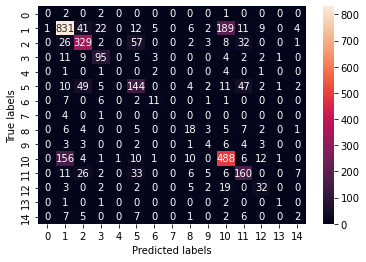

In [154]:
# train test split data
X_train, X_test, y_train, y_test = train_test_split(df_new['title'], 
                                                    df_new['target'], 
                                                    test_size=0.3, 
                                                    stratify = df_new['target'])
    
# vectorising the train and test feature data
X_train_vector = vectorizer.fit_transform(X_train).toarray()

# Transform the test data using the same dictionary as the train data 
X_test_vector = vectorizer.transform(X_test).toarray()
    
# oversampling training data
ros = RandomOverSampler() # initialise sampler
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_vector, y_train)  # fitting resampler to x and y data
print(Counter(y_train_resampled))
    
#initialise classifier
svc = LinearSVC()

# fit the classifier to the training data
svc.fit(X_train_resampled, y_train_resampled)
    
# make the predictions on the test data
y_pred = svc.predict(X_test_vector)

# calculate metrics by comparing predicted values with true values
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average='macro')
recall = metrics.recall_score(y_test, y_pred, average='macro')
f1 = metrics.f1_score(y_test, y_pred, average='macro')
cm = metrics.confusion_matrix(y_test,y_pred)
cm

# plotting confusion matrix
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 

In [156]:
#  iterative loop to run through train-test-split too see how scores compare to cross_validate scores

# empty lists to store metrics
accuracies = []
precisions = []
recalls = []
f1s = []

for i in range(1): # n loops
    
    # train test split data
    X_train, X_test, y_train, y_test = train_test_split(df_new['title'], 
                                                        df_new['target'], 
                                                        test_size=0.3, 
                                                        stratify = df_new['target'])
    
    # vectorising the train and test feature data
    X_train_vector = vectorizer.fit_transform(X_train).toarray()

    # Transform the test data using the same dictionary as the train data 
    X_test_vector = vectorizer.transform(X_test).toarray()
    
    # oversampling training data
    smote = SMOTE() # initialise sampler
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vector, y_train)  # fitting resampler to x and y data
    print(Counter(y_train_resampled))
    
    #initialise classifier
    svc = LinearSVC()

    # fit the classifier to the training data
    svc.fit(X_train_resampled, y_train_resampled)
    
    # make the predictions on the test data
    y_pred = svc.predict(X_test_vector)

    # calculate metrics by comparing predicted values with true values
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred, average='macro')
    recall = metrics.recall_score(y_test, y_pred, average='macro')
    f1 = metrics.f1_score(y_test, y_pred, average='macro')
   
    # append metrics from each iteration to lists
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

Counter({13: 2642, 1: 2642, 10: 2642, 11: 2642, 8: 2642, 12: 2642, 2: 2642, 3: 2642, 5: 2642, 6: 2642, 14: 2642, 4: 2642, 7: 2642, 9: 2642, 0: 2642})


### Quick run through of model on research fields with n+ manuscripts

Running this quick experiment to understand how the presence of minority classes influence model performance. I am removing research fields that have below a certain number of manuscripts and assessing baseline performance metrics.

In [250]:
for_over100 = for_counts[for_counts >= 500].index.tolist()
df_over100 = df_clean[df_clean['for_name'].isin(for_over100)]

print(len(df_clean) - len(df_over100))
print(len(df_over100))
df_over100['for_name'].value_counts()

1252
9386


Biological Sciences            3775
Medical and Health Sciences    2300
Chemical Sciences              1534
Engineering                     923
Physical Sciences               854
Name: for_name, dtype: int64

In [251]:
text_cleanse_1(df_over100,'title')

In [252]:
df_over100

,title,doc_id,n_references,for_name,for_code
0,surface acoustic wave photonic device in silicon on insulator,10.1038/s41467-019-12157-x,54,Physical Sciences,2.0
1,thermal and electrical signature of hydrodynamic electron fluid in tungsten diphosphide,10.1038/s41467-018-06688-y,37,Engineering,9.0
2,phononic integrated circuitry and spin orbit interaction of phonons,10.1038/s41467-019-10852-3,56,Physical Sciences,2.0
3,local josephson vortex generation and manipulation with magnetic force microscope,10.1038/s41467-019-11924-0,54,Physical Sciences,2.0
4,a robust zirconium amino acid metalorganic framework for proton conduction,10.1038/s41467-018-07414-4,59,Chemical Sciences,3.0
...,...,...,...,...,...
11342,apkc control endothelial growth by modulating cmyc via foxo dnabinding ability,10.1038/s41467-018-07739-0,71,Biological Sciences,6.0
11343,single goldbridged nanoprobes for identification of single point dna mutation,10.1038/s41467-019-08769-y,64,Chemical Sciences,3.0
11344,conditional expression explains molecular evolution of social gene in microbe,10.1038/s41467-019-11237-2,63,Biological Sciences,6.0
11345,genetic study link component of the autonomous nervous system to heartrate profile during exercise,10.1038/s41467-018-03395-6,65,Biological Sciences,6.0


In [253]:
# create train and test data split
X_train, X_test, y_train, y_test = train_test_split(df_over100['title'], # features
                                                    df_over100['for_code'], # target
                                                    test_size=0.3, # 70% train, 30% test
                                                    random_state=42, # ensures same split each time to allow repeatability
                                                    shuffle = True, # shuffles data prior to splitting
                                                    stratify = df_over100['for_code']) # distribution of classes across train and test

In [254]:
#  vectorising the train and test feature data
X_train_vector = vectorizer.fit_transform(X_train).toarray()

# Transform the test data using the same dictionary as the train data 
X_test_vector = vectorizer.transform(X_test).toarray()

In [255]:
for model in tqdm(models):
    model_name = model.__class__.__name__
    result = cross_validate(model, X_train_vector, y_train, cv=kf, scoring=scoring)
    print("%s: Mean Accuracy = %.2f%%; Mean F1-macro = %.2f%%; Mean recall-macro = %.2f%%; Mean precision-macro = %.2f%%" 
          % (model_name, 
             result['test_accuracy'].mean()*100, 
             result['test_f1_macro'].mean()*100, 
             result['test_recall_macro'].mean()*100, 
             result['test_precision_macro'].mean()*100))

  0%|          | 0/4 [00:00<?, ?it/s]

RandomForestClassifier: Mean Accuracy = 40.21%; Mean F1-macro = 11.47%; Mean recall-macro = 20.00%; Mean precision-macro = 8.04%
LinearSVC: Mean Accuracy = 72.82%; Mean F1-macro = 67.75%; Mean recall-macro = 66.19%; Mean precision-macro = 70.14%
MultinomialNB: Mean Accuracy = 63.91%; Mean F1-macro = 51.83%; Mean recall-macro = 49.23%; Mean precision-macro = 71.75%
LogisticRegression: Mean Accuracy = 69.65%; Mean F1-macro = 62.67%; Mean recall-macro = 59.17%; Mean precision-macro = 71.30%
